In [1]:
# Install required libraries
!pip install torch torch-geometric matplotlib scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 160.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 15.8 

Node Embeddings: tensor([[ 6.8214e+00, -9.1115e+00],
        [ 8.1622e+00, -1.0116e+01],
        [ 7.8360e+00, -9.7045e+00],
        [ 7.6770e+00, -9.5872e+00],
        [ 1.4641e+04, -1.8728e+04]])


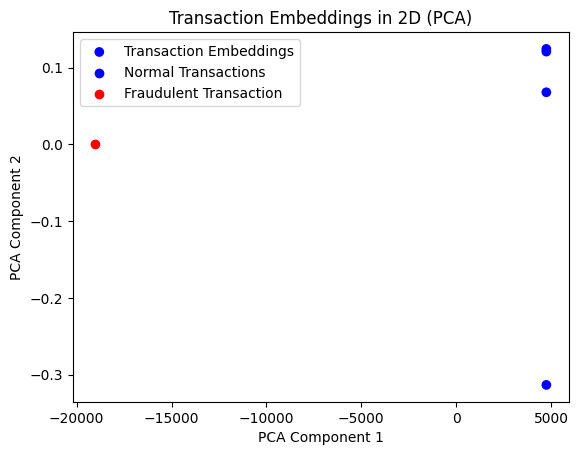

In [4]:
import torch
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Recreate the GraphSAGE model architecture
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = torch.relu(conv(x, edge_index))
        x = self.convs[-1](x, edge_index)  # No activation on the final layer
        return x

# Step 2: Instantiate the model using the same parameters from your job creation step
model = GraphSAGEModel(in_channels=165, hidden_channels=256, num_layers=3, out_channels=2)

# Step 3: Load the state dictionary from the 'model' key in the checkpoint
model_path = '/tmp/nvflare/gnn/finance_fl_workspace/simulate_job/app_server/FL_global_model.pt'
checkpoint = torch.load(model_path, weights_only=True)

# Extract the model's state_dict from the checkpoint
state_dict = checkpoint['model']

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Step 4: Set the model to evaluation mode
model.eval()

# Step 5: Prepare some dummy transaction data
node_features = torch.rand((5, 165))  # Random features for the transactions
# Modify one transaction to simulate fraud (e.g., set higher values)
node_features[4] = torch.tensor([1000.0] * 165)  # Transaction 5 is set as fraudulent

# Define the relationships between the transactions
edge_index = torch.tensor([[0, 1, 2, 3, 4],  # From nodes (transactions)
                           [1, 0, 3, 2, 4]], dtype=torch.long)  # To nodes (transactions)

# Create a PyTorch Geometric Data object
new_transaction_data = Data(x=node_features, edge_index=edge_index)

# Step 6: Extract node embeddings
with torch.no_grad():
    node_embeddings = model(new_transaction_data.x, new_transaction_data.edge_index)

print("Node Embeddings:", node_embeddings)

# Step 7: Visualize the embeddings using PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(node_embeddings)

# Define colors: red for the fraudulent transaction (index 4), blue for others
colors = ['blue'] * 4 + ['red']  # Assuming transaction 5 (index 4) is the fraudulent one

# Plot the embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, label='Transaction Embeddings')
plt.title('Transaction Embeddings in 2D (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Add legend
plt.scatter([], [], c='blue', label='Normal Transactions')
plt.scatter([], [], c='red', label='Fraudulent Transaction')
plt.legend()

plt.show()

